# Amazon Bedrock boto3 Setup

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

For more details refer to the [`Bedrock` Workshop](https://github.com/aws-samples/amazon-bedrock-workshop)

---

## Prerequisites

Run the cells in this section to install the packages needed by the notebooks in this workshop. ⚠️ You will see pip dependency errors, you can safely ignore these errors. ⚠️

IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [2]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"
%pip install "unstructured[csv]" "pillow>=9.5,<10" langchain==0.0.309 python-weather pypdf==3.8.1 faiss-cpu==1.7.4 --force-reinstall --quiet

  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached docutils-0.16-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl.metadata (14 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached pyasn1-0.5.1-py2.py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 36.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 40.2 MB/s eta 0:00:00:00:010:01
Using cached colorama-0.4.4-py2.py3-none-any.whl (16 kB)
Using cached docutils-0.16-py2.py3-no

In [3]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Bedrock clients
This notebook demonstrates invoking Bedrock models directly using the AWS SDK

Here are links for some packages you might not be familiar with:

- [FAISS](https://github.com/facebookresearch/faiss), to store vector embeddings
- [sqlalchemy](https://www.sqlalchemy.org/), SQLAlchemy is the Python SQL toolkit 
- [PyPDF](https://pypi.org/project/pypdf/), for handling PDF files
- [IPyWidgets](https://ipywidgets.readthedocs.io/en/stable/), for interactive UI widgets in the notebook
- [NeMo-Guardrails](https://github.com/NVIDIA/NeMo-Guardrails) an open-source toolkit for easily adding programmable guardrails to LLM-based conversational systems


---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

Depending on your environment, you might need to customize the setup when creating your Bedrock service client. To help with this, we've provided a `get_bedrock_client()` utility method that supports passing in different options. You can find the implementation in [../utils/bedrock.py](../utils/bedrock.py)

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).

The `get_bedrock_client()` method accepts `runtime` (default=True) parameter to return either `bedrock` or `bedrock-runtime` client.

#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.

#### Use a different AWS Region

If you're running this notebook from your own computer or a SageMaker notebook in a different AWS Region from where Bedrock is set up, you can un-comment the `os.environ['AWS_DEFAULT_REGION']` line below and specify the region to use.

#### Use a specific profile

In case you're running this notebook from your own computer where you have setup the AWS CLI with multiple profiles, and the profile which has access to Bedrock is not the default one, you can un-comment the `os.environ['AWS_PROFILE']` line below and specify the profile to use.

#### Use a different role

In case you or your company has setup a specific, separate [IAM Role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) to access Bedrock, you can specify it by un-commenting the `os.environ['BEDROCK_ASSUME_ROLE']` line below. Ensure that your current user or role have permissions to [assume](https://docs.aws.amazon.com/STS/latest/APIReference/API_AssumeRole.html) such role.

#### A note about `langchain`

The Bedrock classes provided by `langchain` create a Bedrock boto3 client by default. To customize your Bedrock configuration, we recommend to explicitly create the Bedrock client using the method below, and pass it to the [`langchain.Bedrock`](https://python.langchain.com/docs/integrations/llms/bedrock) class instantiation method using `client=boto3_bedrock`

In [4]:
import json
import os
from pprint import pprint
import sys
import boto3
import botocore

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

os.environ["AWS_DEFAULT_REGION"] = "us-east-1"
# os.environ["AWS_PROFILE"] = ""
# os.environ["BEDROCK_ASSUME_ROLE"] = ""  # E.g. "arn:aws:..."

bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None))

model_parameter = {"temperature": 0.0, "top_p": .5, "max_tokens_to_sample": 2000}

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Invoke Model

we will demonstrate the use of invoking the models and also highlight the default behaviour of LLM. They will return answer and data based on the training data. For our use case of AiStylist we need more curated responses. That means we will need to adopt a different architecture to get the model to execute our use case. Those techniques will be demonstrated in the next workbook

In [5]:
# If you'd like to try your own prompt, edit this parameter!
customer_input = "I am a male consultant in my 30s traveling to New York next week. What kind of outfit should I wear on my first day in the office? "

In [6]:
# first fetch possible styles and give options to customer
prompt = """

Human: list different style options for:
""" + customer_input + """

Assistant:"""
body = json.dumps({"prompt": prompt, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-v2"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"
claudeResponse = ""

response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())
styles_response = response_body.get("completion")
print(styles_response)


 Here are some different professional style options for a male consultant in his 30s visiting the office in New York:

Business formal:
- A tailored two-piece suit in a neutral color like navy, gray, or black. Pair with a dress shirt, conservative tie, dress shoes, and a belt.

- A blazer or sport coat with dress pants, dress shirt, and tie. Opt for classic patterns like plaid, houndstooth, or solids.

Business casual: 
- Dress pants or chinos with a button-up collared shirt. Could layer with a merino sweater or knit blazer.

- Dark jeans or chinos with an Oxford shirt or polo shirt. Add loafers or leather boots.

- A fitted blazer or sport coat with a dress shirt and smart jeans or chinos.

Some other tips:
- Stick to versatile, neutral colors that easily mix and match. 
- Quality fabrics like wool, cotton, linen will project professionalism.
- Shoes should be leather dress shoes or boots, cleaned and polished. 
- Accessories like a nice watch, leather bag, or subtle patterned tie com

In [7]:
pprint(body)
pprint(response_body)


('{"prompt": "\\n\\nHuman: list different style options for:\\nI am a male '
 'consultant in my 30s traveling to New York next week. What kind of outfit '
 'should I wear on my first day in the office? \\n\\nAssistant:", '
 '"max_tokens_to_sample": 500}')
{'completion': ' Here are some different professional style options for a male '
               'consultant in his 30s visiting the office in New York:\n'
               '\n'
               'Business formal:\n'
               '- A tailored two-piece suit in a neutral color like navy, '
               'gray, or black. Pair with a dress shirt, conservative tie, '
               'dress shoes, and a belt.\n'
               '\n'
               '- A blazer or sport coat with dress pants, dress shirt, and '
               'tie. Opt for classic patterns like plaid, houndstooth, or '
               'solids.\n'
               '\n'
               'Business casual: \n'
               '- Dress pants or chinos with a button-up collared shirt. Could

## Generate the default images using stability.stable-diffusion-xl

Preparing received response to generate images for each style look

In [8]:
# Prepare input for fetching images for each of style
styles = [s.strip() for s in (list(filter(None, styles_response.splitlines()))[1:-1])]
print(*styles, sep='\n')

Business formal:
- A tailored two-piece suit in a neutral color like navy, gray, or black. Pair with a dress shirt, conservative tie, dress shoes, and a belt.
- A blazer or sport coat with dress pants, dress shirt, and tie. Opt for classic patterns like plaid, houndstooth, or solids.
Business casual:
- Dress pants or chinos with a button-up collared shirt. Could layer with a merino sweater or knit blazer.
- Dark jeans or chinos with an Oxford shirt or polo shirt. Add loafers or leather boots.
- A fitted blazer or sport coat with a dress shirt and smart jeans or chinos.
Some other tips:
- Stick to versatile, neutral colors that easily mix and match.
- Quality fabrics like wool, cotton, linen will project professionalism.
- Shoes should be leather dress shoes or boots, cleaned and polished.
- Accessories like a nice watch, leather bag, or subtle patterned tie complete the look.
- Ensure clothes are neatly pressed, and well-fitted to your frame.


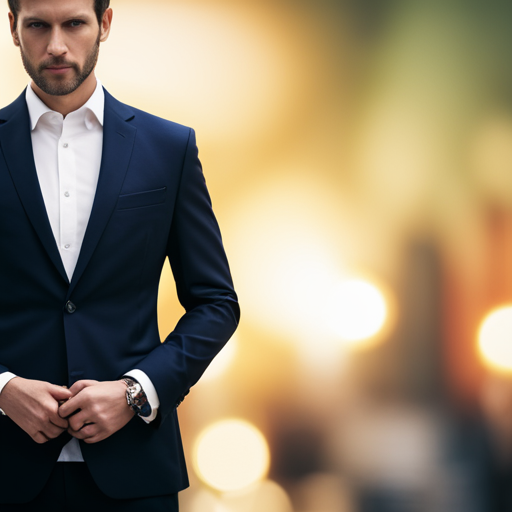

FileNotFoundError: [Errno 2] No such file or directory: 'data/intro/image_1.png'

In [9]:
from PIL import Image
from IPython import display
from base64 import b64decode
import base64
import io
import json
import os
import sys

# Fetching images for each of style

os.makedirs("data", exist_ok=True)
images = []
for i, style in enumerate(styles):
    if len(style.split("-")) > 1:
        request = json.dumps({
            "text_prompts": (
                [{"text": "person wearing " + style.split("-")[1], "weight": 1.0}]
            ),
            "cfg_scale": 5,
            "seed": 5450,
            "steps": 70,
            "style_preset": "photographic",
        })
        modelId = "stability.stable-diffusion-xl"
        
        response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
        response_body = json.loads(response.get("body").read())
        
        base_64_img_str = response_body["artifacts"][0].get("base64")
        display.display(display.Image(b64decode(base_64_img_str), width=200))
        with open(f"data/intro/image_{i}.png", "wb") as fh:
            fh.write(base64.decodebytes(bytes(base_64_img_str, "utf-8")))